<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview-of-the-Hi-C-experiment" data-toc-modified-id="Overview-of-the-Hi-C-experiment-1">Overview of the Hi-C experiment</a></span><ul class="toc-item"><li><span><a href="#Choose-the-restriction-enzyme" data-toc-modified-id="Choose-the-restriction-enzyme-1.1">Choose the restriction enzyme</a></span><ul class="toc-item"><li><span><a href="#Example-with-different-restriction-enzymes-and-double-digestion" data-toc-modified-id="Example-with-different-restriction-enzymes-and-double-digestion-1.1.1">Example with different restriction enzymes and double digestion</a></span></li><li><span><a href="#Distribution-of-the-restriction-fragment-sizes" data-toc-modified-id="Distribution-of-the-restriction-fragment-sizes-1.1.2">Distribution of the restriction fragment sizes</a></span></li><li><span><a href="#Number-of-cut-sites-per-bin-in-chromosome-19" data-toc-modified-id="Number-of-cut-sites-per-bin-in-chromosome-19-1.1.3">Number of cut-sites per bin in chromosome 19</a></span></li></ul></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-2">References</a></span></li></ul></div>

# Overview of the Hi-C experiment

![Hic Expriment](images/hic_experiment.png)

Adapted from <a name="ref-1" align="right">[Lieberman et al. 2009](#cite-lieberman2009)</a>

## Choose the restriction enzyme

One of the the most important decision when designing an Hi-C experiment is the choice of the restriction enzyme (RE).
 
The RE must fulfill a list of desiderata to ensure the formation of ligated fragments:
 - The resulting cut-site must present a 3' overhang. Without it the reparation process cannot insert the nucleotide marked with biotin.
 - The RE should be able to cut optimally in conditions (pH, temperature) compatible with the experiment.
 - The RE should not be affected by the GC content around the target sequence.
 - The site resulting from the ligation of two repaired cut-sites should be recognizable in order to perform the bioinformatic processing.
 - The cut-site should have an almost __homogeneous distribution__ along the genome in order to avoid biases.
 - The cut frequency of the RE should be sufficienty high to allow for a good resolution. __More cut-sites mean higher resolution__.
 - Several __restriction enzymes can be combined__, but having __too many cut-sites may also not be a good idea__, because the average restriction fragment has to be longer than the sequenced fragments.
 - The __region(s) of interest should have high density of cut-sites__. Some genome browsers allow to load tracks corresponding to the cut-sites of several restriction enzymes (e.g. https://genome.ucsc.edu/)

TADbit has a dedicated set of functions to help in the choice of the optimal restriction enzyme(s) for the species of interest. We assume that all needed software is installed (Notebook [Materials-2-Preparing your computer for the HiC data analysis](Materials-2-Preparing%20your%20computer%20for%20the%20HiC%20data%20analysis.ipynb)) and the reference genome (Notebook [Methods-2-Preparation of the reference genome](Methods-2-Preparation%20of%20the%20reference%20genome.ipynb)) prepared for the analysis.
First we need to load the _Mouse_ genomic sequence:

In [7]:
from pytadbit.parsers.genome_parser import parse_fasta
from matplotlib import pyplot as plt

In [8]:
genome_seq = parse_fasta('genome/Mus_musculus-GRCm38.p6/Mus_musculus-GRCm38.p6.fa', 
                         reload_cache=True)

Parsing chr1
Parsing chr2
Parsing chr3
Parsing chr4
Parsing chr5
Parsing chr6
Parsing chr7
Parsing chr8
Parsing chr9
Parsing chr10
Parsing chr11
Parsing chr12
Parsing chr13
Parsing chr14
Parsing chr15
Parsing chr16
Parsing chr17
Parsing chr18
Parsing chr19
Parsing chrX
Parsing chrY
Parsing chrMT
saving genome in cache


We have loaded the full mouse genome, we can plot the size of each chromosome:

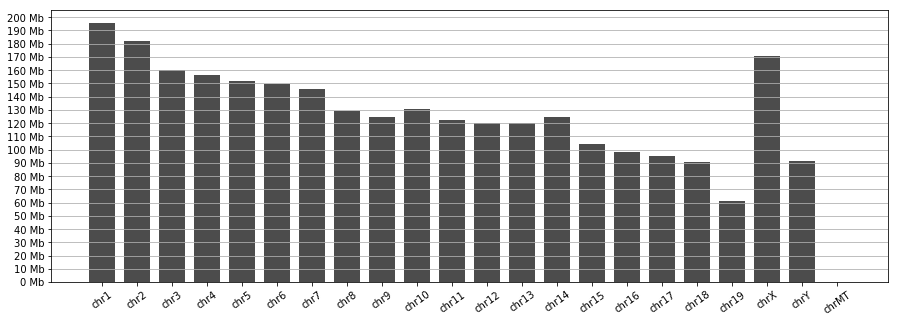

In [21]:
genome_lens = [len(genome_seq[c]) for c in genome_seq]
plt.figure(figsize=(15, 5))
plt.bar(range(len(genome_seq)), [len(genome_seq[c]) for c in genome_seq], 
        color='k', alpha=0.7, width=0.75)
_ = plt.xticks([v for v in range(len(genome_seq))], genome_seq.keys(), rotation=35)
_ = plt.yticks([v for v in range(0, max(genome_lens) + 10000000, 10000000)],
               ['%d Mb' % (v / 1000000) for v in range(0, max(genome_lens) + 10000000, 10000000)])
plt.axes().yaxis.grid()
plt.show()

Then, we search for restriction enzyme sites in this sequence.

### Example with different restriction enzymes and double digestion

In [22]:
from pytadbit.mapping.restriction_enzymes import map_re_sites

In [23]:
print 'MboI\n -',
frags_MboI    = map_re_sites('MboI'              , genome_seq, verbose=True)

print 'HindIII\n -',
frags_HindIII = map_re_sites('HindIII'           , genome_seq, verbose=True)

print 'NcoI\n -',
frags_NcoI    = map_re_sites('NcoI'              , genome_seq, verbose=True)

print 'HindIII & MboI\n -',
frags_double  = map_re_sites(['HindIII', 'MboI'] , genome_seq, verbose=True)

MboI
 - Found 6669655 RE sites
HindIII
 - Found 849922 RE sites
NcoI
 - Found 862336 RE sites
HindIII & MboI
 - Found 7519577 RE sites


_Note: TADbit is compatible with __any number of restriction enzymes__, if using more than two is a good idea..._

In [24]:
max_size = 30000
c0 = 'chr1'
v0 = 0
dists_MboI = []
for c1, v1 in [(c, v) for c in frags_MboI for p in frags_MboI[c] 
               for v in frags_MboI[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < max_size:  # larger fragments are probably poorly assembled regions
            dists_MboI.append(diff)
    v0 = v1

v0 = 0
dists_HindIII = []
for c1, v1 in [(c, v) for c in frags_HindIII for p in frags_HindIII[c] 
               for v in frags_HindIII[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < max_size:  # larger fragments are probably poorly assembled regions
            dists_HindIII.append(diff)
    v0 = v1

v0 = 0
dists_NcoI = []
for c1, v1 in [(c, v) for c in frags_NcoI for p in frags_NcoI[c] 
               for v in frags_NcoI[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < max_size:  # larger fragments are probably poorly assembled regions
            dists_NcoI.append(diff)
    v0 = v1

v0 = 0
dists_double = []
for c1, v1 in [(c, v) for c in frags_double for p in frags_double[c] 
               for v in frags_double[c][p]]:
    if c1 == c0:
        diff = abs(v1 - v0)
        if diff < max_size:  # larger fragments are probably poorly assembled regions
            dists_double.append(diff)
    v0 = v1


### Distribution of the restriction fragment sizes

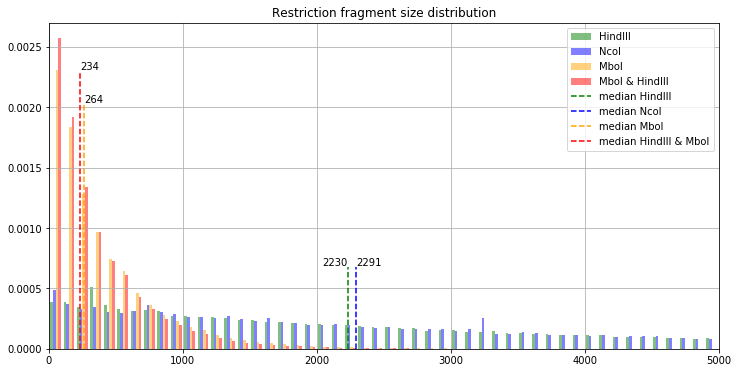

In [28]:
import numpy as np
plt.figure(figsize=(12, 6))
_ = plt.hist([dists_HindIII, dists_NcoI, dists_MboI, dists_double], bins=50, 
             color=['green', 'blue', 'orange', 'red'], 
             alpha=0.5, label=['HindIII', 'NcoI', 'MboI', 'MboI & HindIII'], range=(0, 5000), normed=True)
y0, y1 = plt.ylim()
plt.vlines(np.median(dists_HindIII), y0, y1 * 0.25, color='green', linestyle='--',
          label='median HindIII')
plt.vlines(np.median(dists_NcoI)   , y0, y1 * 0.25, color='blue', linestyle='--',
          label='median NcoI')
plt.vlines(np.median(dists_MboI), y0, y1 * 0.75, color='orange', linestyle='--',
          label='median MboI')
plt.vlines(np.median(dists_double)   , y0, y1 * 0.85, color='red', linestyle='--',
          label='median HindIII & MboI')
plt.text(np.median(dists_MboI), y1 * 0.75, '%.0f' % np.median(dists_MboI), va='bottom', 
         ha='left')
plt.text(np.median(dists_HindIII), y1 * 0.25, '%.0f' % np.median(dists_HindIII), va='bottom', 
         ha='right')
plt.text(np.median(dists_NcoI)   , y1 * 0.25,'%.0f' % np.median(dists_NcoI)   , va='bottom', 
         ha='left')
plt.text(np.median(dists_double)   , y1 * 0.85,'%.0f' % np.median(dists_double)   , va='bottom', 
         ha='left')
plt.title('Restriction fragment size distribution')
plt.legend()
plt.grid()
plt.xlim(0, 5000)
plt.show()

There is a big improvement when passing from a six base-pair cutter (such as HindIII or NcoI) to a four base-pair cutter (such as MboI). However, it is clear that combining two REs, here HindIII + MboI, may not allow much shorter fragments.

### Number of cut-sites per bin in chromosome 19

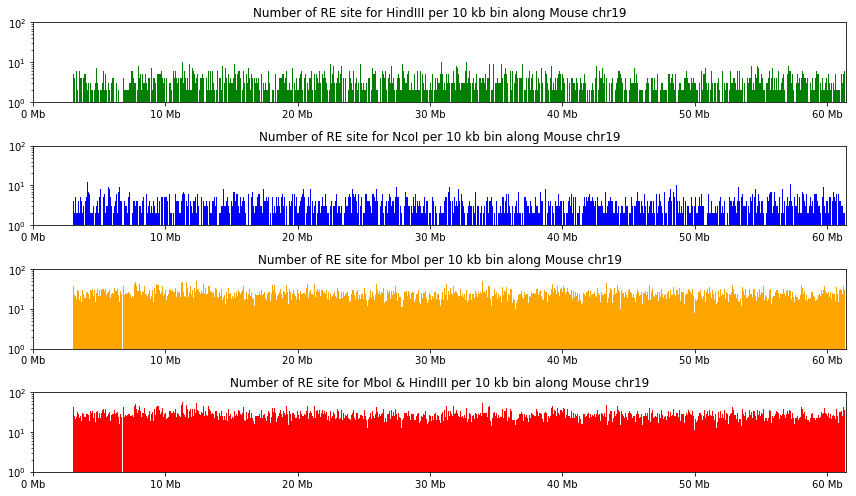

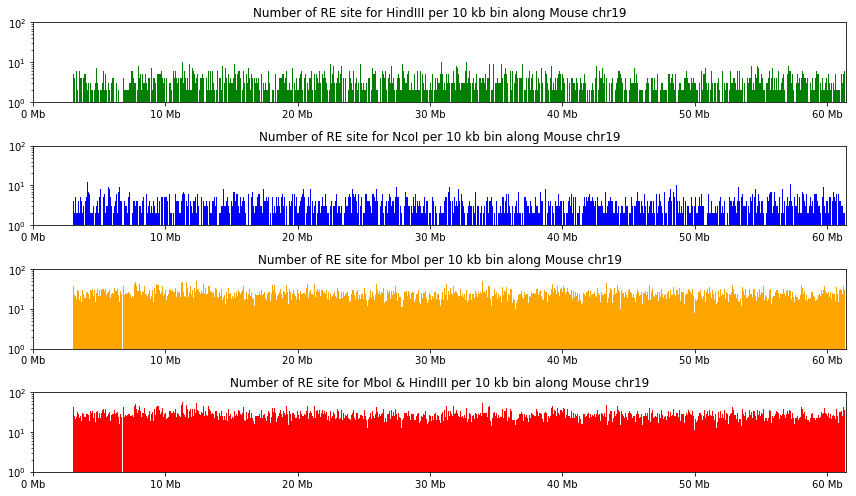

In [30]:
c = 'chr19'
reso = 10000
ax = None
plt.figure(figsize=(12, 7))
for pos, name, col, num in zip([frags_HindIII, frags_NcoI, frags_MboI, frags_double],
                               ['HindIII', 'NcoI', 'MboI', 'MboI & HindIII'],
                               ['green', 'blue', 'orange', 'red'],
                               range(4)):
    ax = plt.subplot(4, 1, num + 1, sharex=ax)
    pos = list(set(reduce(lambda x, y: x + y, [pos[c][k] for k in pos[c]])))
    mpos = max(pos)
    _ = plt.hist(pos, bins=mpos / reso, color=col, range=(0, mpos))
    plt.title('Number of RE site for %s per %s kb bin along Mouse %s' % (name, reso / 1000, c))
    plt.xlim((0, mpos))
    plt.xticks(range(0, mpos + reso, 10000000), 
               ['%d Mb' % (p / 1000000) for p in xrange(0, mpos + reso, 10000000)])
    plt.yscale('log')
    plt.ylim(0, 100)
plt.tight_layout()
plt.show()

When using a six base-pair cutter, a resolution of 10 kb may be out of reach as many bins will have not cut-sites at all. Using a four base-pair cutter, the number of cut-sites per 10kb-bin would be between 15 and 30 allowing for __more robust measurements__.

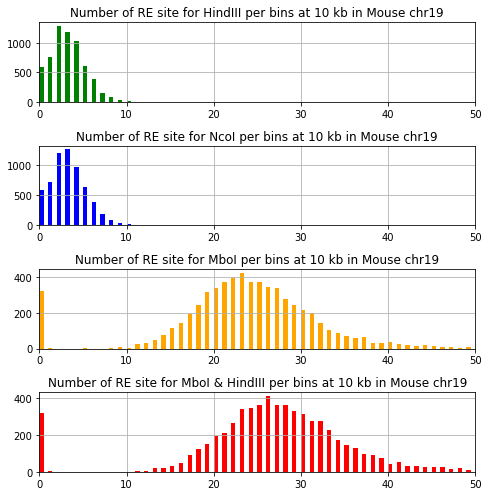

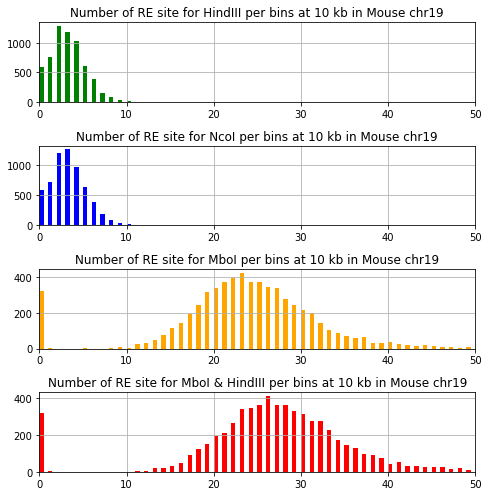

In [32]:
c = 'chr19'
reso = 10000
ax = None
plt.figure(figsize=(7, 7))
for pos, name, col, num in zip([frags_HindIII, frags_NcoI, frags_MboI, frags_double],
                               ['HindIII', 'NcoI', 'MboI', 'MboI & HindIII'],
                               ['green', 'blue', 'orange', 'red'],
                               range(4)):
    ax = plt.subplot(4, 1, num + 1, sharex=ax)
    pos = list(set(reduce(lambda x, y: x + y, [pos[c][k] for k in pos[c]])))
    mpos = max(pos)
    counts, bins = np.histogram(pos, bins=mpos / reso, range=(0, mpos))
    _ = plt.hist(counts, color=col, bins=50, range=(0, 50), width=0.5)
    plt.title('Number of RE site for %s per bins at %s kb in Mouse %s' % (name, reso / 1000, c))
    plt.xlim((0, 50))
    plt.grid()
plt.tight_layout()
plt.show()

# References

<a name="cite-lieberman2009"/><sup>[^](#ref-1) </sup> Lieberman-Aiden E1, van Berkum NL, Williams L, Imakaev M, Ragoczy T, Telling A, Amit I, Lajoie BR, Sabo PJ, Dorschner MO, Sandstrom R, Bernstein B, Bender MA, Groudine M, Gnirke A, Stamatoyannopoulos J, Mirny LA, Lander ES, Dekker J. _Comprehensive mapping of long-range interactions reveals folding principles of the human genome._ Science. 2009 Oct 9;326(5950):289-93


<!--bibtex
@article{le2014distinct,
  title={Distinct structural transitions of chromatin topological domains correlate with coordinated hormone-induced gene regulation},
  author={Le Dily, Fran{\c{c}}ois and Ba{\`u}, Davide and Pohl, Andy and Vicent, Guillermo P and Serra, Fran{\c{c}}ois and Soronellas, Daniel and Castellano, Giancarlo and Wright, Roni HG and Ballare, Cecilia and Filion, Guillaume and others},
  journal={Genes \& development},
  volume={28},
  number={19},
  pages={2151--2162},
  year={2014},
  publisher={Cold Spring Harbor Lab}
}
@article{roguski2014dsrc,
  title={DSRC 2—Industry-oriented compression of FASTQ files},
  author={Roguski, {\L}ukasz and Deorowicz, Sebastian},
  journal={Bioinformatics},
  volume={30},
  number={15},
  pages={2213--2215},
  year={2014},
  publisher={Oxford Univ Press}
}
-->